## Import Modules

In [1]:
import re, sys, os
import logging
from pathlib import Path
from datetime import datetime
import torch
import torch_directml
from fastai.vision.all import *
from fastai.vision.augment import _init_mat


torch._logging.set_logs(all=logging.INFO)

In [ ]:
print("="*80)
print("DIRECTML FULL DEBUG LOG STARTED")
print(f"torch version: {torch_directml.torch.__version__}")
print(f"Device: {torch_directml.device()}")
print(f"GPU: {torch_directml.device_name(0)}")
print("="*80)

DIRECTML FULL DEBUG LOG STARTED
torch version: 2.4.1+cpu
Device: privateuseone:0
GPU: Radeon RX 560X 


In [3]:
# 1. Detect DirectML device (no global default!)
dml = torch_directml.device()
print("="*80)

# # 3. Global monkey-patch for Normalize (fixes later device mismatch in transforms)
old_init = Normalize.__init__
def new_init(self, mean, std, axes=(0,2,3)):
    old_init(self, mean.to(dml), std.to(dml), axes=axes)
Normalize.__init__ = new_init

In [ ]:
from fastai.learner import Learner

# Solves the gradient issue. without this, training will be done but
# the error/loss will not be converged/reduced.
def directml_safe_freeze_to(self: Learner, n: int):
    backbone = self.model[0]
    backbone_ids = {id(p) for p in backbone.parameters()}
    
    # ONLY set requires_grad (DirectML-safe)
    if n == 0:
        for p in self.model.parameters():
            p.requires_grad_(True)
    else:
        for p in backbone.parameters():
            p.requires_grad_(False)
        for p in self.model.parameters():
            if id(p) not in backbone_ids:
                p.requires_grad_(True)

    if self.opt is not None:
        self.opt.clear_state()
    
    print(f"DirectML-safe freeze_to({n}) — requires_grad set")

Learner.freeze_to = directml_safe_freeze_to

## Set device to Torch-DirectML detected device

## Load Data to train on

In [5]:
# 4. Load data (splitting now uses CPU randperm, no crash)
path = untar_data(URLs.PETS)
files = get_image_files(path / "images")

## Create Fastai DataLoaders

In [ ]:
def is_cat(x): return x[0].isupper()

dls = ImageDataLoaders.from_name_func(
    path, files,
    valid_pct=0.2,
    seed=42,
    label_func=is_cat,
    item_tfms=Resize(224),
    bs=32,  # Adjust based on your GPU VRAM (e.g., 32 for lower-end)
    device=dml  # Pin batches to DirectML
    # num_workers=0  # Avoid multiprocessing issues with DirectML
)

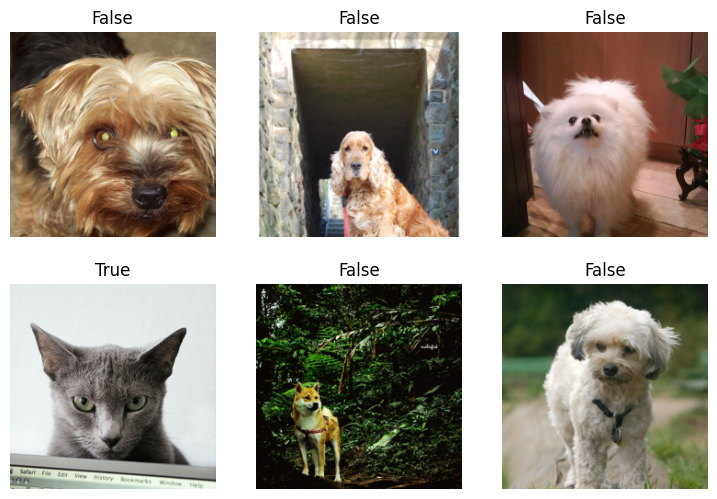

In [7]:
# Show one batch to verify labels are correct
dls.show_batch(max_n=6)

In [8]:
test_file = files[0]
print("="*80)
print(f"File: {test_file.name}, Label: {test_file.name[0].isupper()}")

File: Abyssinian_1.jpg, Label: True


## Create Learner
### Transfer model and everything to Torch-DirectML detected device

In [ ]:
# 5. Create learner on CPU first, then move to DML
learn = vision_learner(dls, resnet34, metrics=[error_rate, accuracy]) # resnet18, 34, 50, 101, 152
learn = learn.to_fp16(enabled=False)   # ← disables mixed precision completely
learn.to(dml)  # Explicitly move to DirectML
""

DirectML-safe freeze_to(-1) — requires_grad set


''

## Start the training/fine-tuning

In [10]:
print("="*80)
learn.fine_tune(epochs=1)
print("="*80)

DirectML-safe freeze_to(-1) — requires_grad set


f:\Projects\VsCodium\Python\2025\GenAI\11\.venv3_12_9\Lib\site-packages\torch\amp\autocast_mode.py:265: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
f:\Projects\VsCodium\Python\2025\GenAI\11\.venv3_12_9\Lib\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


f:\Projects\VsCodium\Python\2025\GenAI\11\.venv3_12_9\Lib\site-packages\torch\nn\functional.py:1166: UserWarning: The operator 'aten::adaptive_max_pool2d.out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  return torch._C._nn.adaptive_max_pool2d(input, output_size)


DirectML-safe freeze_to(0) — requires_grad set


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.060874,0.028209,0.006089,0.993911,06:13


In [11]:
test_path = Path('test_images')

for file in test_path.iterdir():
    is_cat, _, probs = learn.predict(file)
    print(is_cat, _, probs)
    pred_msg = (
        f"{file.name} is a {'cat' if     _.item() == 1 else 'dog'} "
        f"with probability {probs[bool(is_cat)]}"
    )
    print(pred_msg)


True tensor(1) tensor([9.9375e-10, 1.0000e+00])
test_c1.jpg is a cat with probability tensor([[9.9375e-10, 1.0000e+00]])


True tensor(1) tensor([2.5807e-07, 1.0000e+00])
test_c2.jpg is a cat with probability tensor([[2.5807e-07, 1.0000e+00]])


True tensor(1) tensor([4.8074e-20, 1.0000e+00])
test_c3_warped.jpg is a cat with probability tensor([[4.8074e-20, 1.0000e+00]])


True tensor(1) tensor([1.2601e-08, 1.0000e+00])
test_c4_warped.jpg is a cat with probability tensor([[1.2601e-08, 1.0000e+00]])


True tensor(1) tensor([7.2144e-19, 1.0000e+00])
test_c5_warped.jpg is a cat with probability tensor([[7.2144e-19, 1.0000e+00]])


False tensor(0) tensor([9.9998e-01, 1.6263e-05])
test_d1.jpg is a dog with probability tensor([[9.9998e-01, 1.6263e-05]])


False tensor(0) tensor([9.9995e-01, 5.0345e-05])
test_d2.jpg is a dog with probability tensor([[9.9995e-01, 5.0345e-05]])


False tensor(0) tensor([0.8653, 0.1347])
test_d3_color.jpg is a dog with probability tensor([[0.8653, 0.1347]])


False tensor(0) tensor([9.9990e-01, 9.6317e-05])
test_d4_color.jpg is a dog with probability tensor([[9.9990e-01, 9.6317e-05]])


False tensor(0) tensor([9.9984e-01, 1.5575e-04])
test_d5.jpg is a dog with probability tensor([[9.9984e-01, 1.5575e-04]])


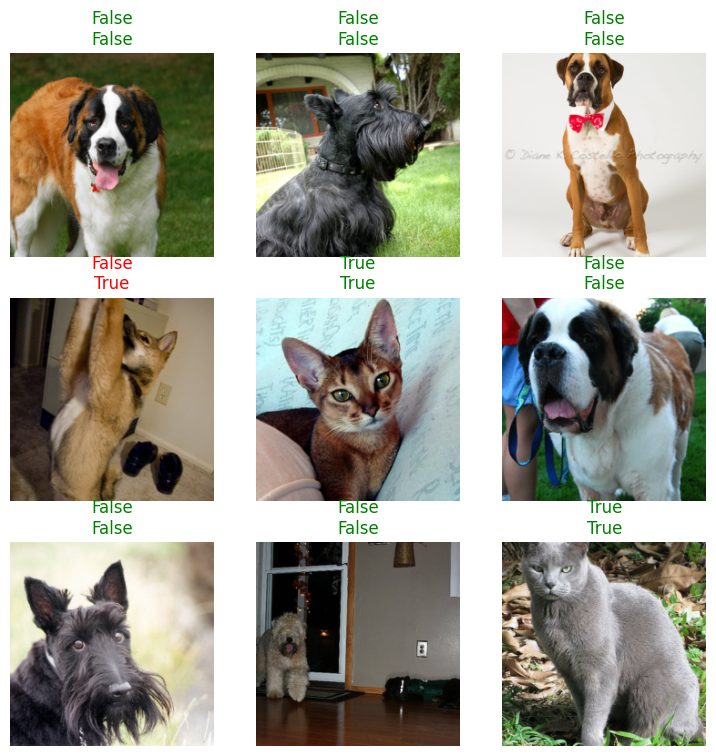

In [12]:
learn.show_results()

In [15]:
interpreter = ClassificationInterpretation.from_learner(learn)

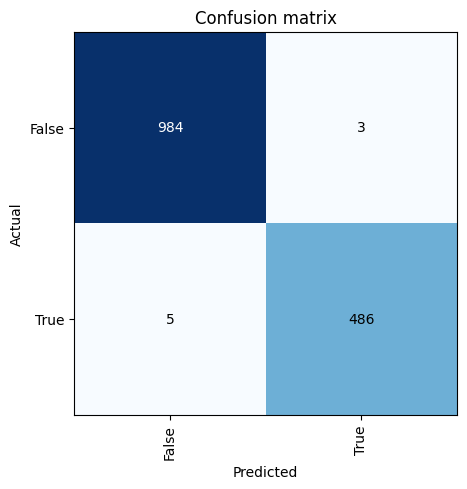

In [16]:
interpreter.plot_confusion_matrix()

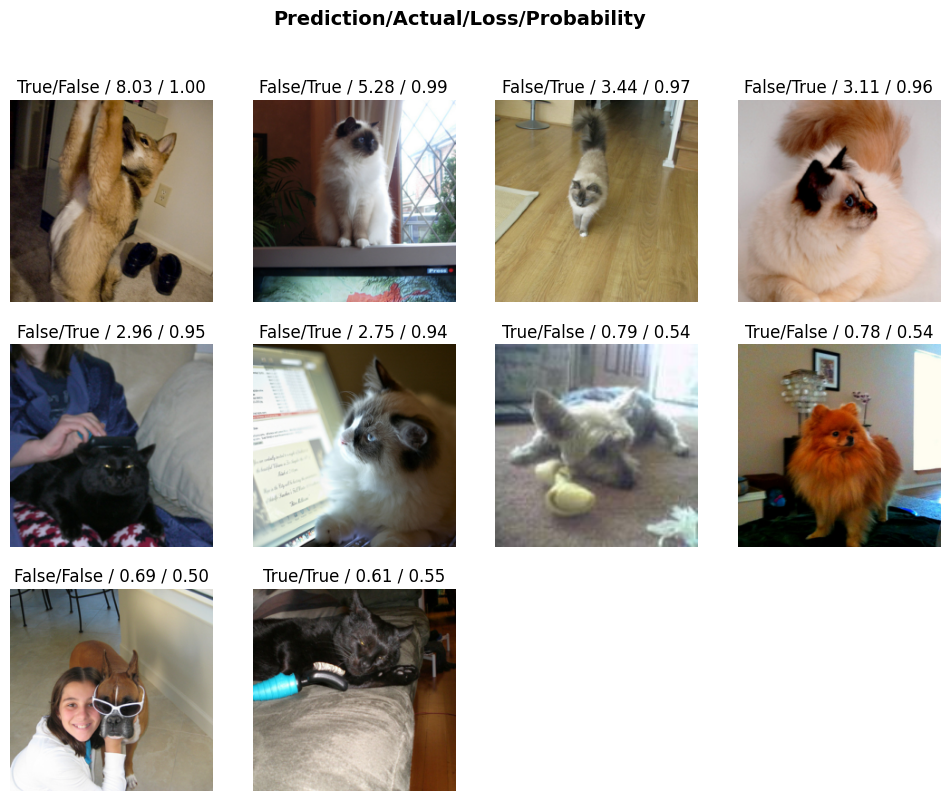

In [17]:
interpreter.plot_top_losses(k=10)